In [1]:
import numpy as np
import nltk
import pandas as pd
from nltk.tag.hmm import HiddenMarkovModelTagger
from nltk import FreqDist
from collections import Counter


The function below:

- reads the CSV file  
- splits the *text* field into words  
- splits the *tags* field into POS labels  
- checks that words and tags match in length  
- returns a list of `(word, tag)` sequences

In [2]:
def load_ud_csv(path):
    df = pd.read_csv(path, encoding="latin1")
    sentences = []
    for _, row in df.iterrows():
        words = row["text"].split()
        tags = row["tags"].split()
        assert len(words) == len(tags)
        sentences.append(list(zip(words, tags)))
    return sentences


In [3]:
train = load_ud_csv("datasets/ud_basque/ud_basque_train.csv")
dev   = load_ud_csv("datasets/ud_basque/ud_basque_dev.csv")
test  = load_ud_csv("datasets/ud_basque/ud_basque_test.csv")

print(len(train), len(dev), len(test))


5396 1798 1799


In [4]:
print("Ejemplo de oración en el train:")
print(train[0])


Ejemplo de oración en el train:
[('Gero', 'ADV'), (',', 'PUNCT'), ('lortutako', 'VERB'), ('masa', 'NOUN'), ('molde', 'NOUN'), ('batean', 'NUM'), ('jarri', 'VERB'), ('.', 'PUNCT')]


In [5]:
print("Nº oraciones entreno:", len(train))
print("Nº oraciones dev:", len(dev))
print("Nº oraciones test:", len(test))


Nº oraciones entreno: 5396
Nº oraciones dev: 1798
Nº oraciones test: 1799


In [6]:
all_tags = [tag for sent in train for (_, tag) in sent]
tagset = set(all_tags)
print("Tags encontrados:", tagset)
print("Número total:", len(tagset))


Tags encontrados: {'VERB', 'AUX', 'PUNCT', 'SYM', 'ADV', 'PRON', 'NOUN', 'DET', 'PART', 'ADP', 'CCONJ', 'INTJ', 'SCONJ', 'ADJ', 'NUM', 'PROPN', 'X'}
Número total: 17


Here we compute the frequency of each POS tag in the training set.
This is directly related to the theory discussed in class:

- HMMs estimate transition and emission probabilities from tag frequencies
- Frequent tags contribute more to probability estimates
- Rare tags are more affected by data sparsity

The plotted distribution helps visualize which tags dominate the corpus and anticipate challenges during training.

<Axes: title={'center': 'Distribución de tags UD (Euskera)'}, xlabel='Samples', ylabel='Counts'>

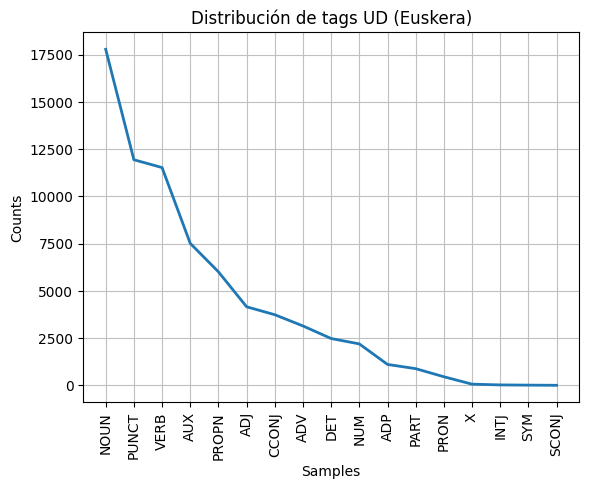

In [7]:
freq = FreqDist(all_tags)
freq.plot(30, title="Distribución de tags UD (Euskera)")


A Hidden Markov Model represents POS tagging through the joint probability:

\[
P(X, Y) = \prod_{i=1}^{n} P(y_i \mid y_{i-1}) \cdot P(x_i \mid y_i)
\]

Where:

- \(X = (x_1, x_2, \dots, x_n)\) are the observed words  
- \(Y = (y_1, y_2, \dots, y_n)\) are the hidden POS tags  
- \(P(y_i \mid y_{i-1})\) is the **transition probability**  
- \(P(x_i \mid y_i)\) is the **emission probability**  
- \(P(y_1)\) is the **initial state distribution**

The training procedure uses *Maximum Likelihood Estimation (MLE)* based on counting:

- tag transitions  
- tag→word emissions  
- initial tags at the start of sentences

`HiddenMarkovModelTagger.train()` automatically computes all these estimates from the training data.


In [31]:
tagger = HiddenMarkovModelTagger.train(train)


We evaluate the model using **token-level accuracy**, defined as:

\[
\text{accuracy} = 
\frac{\text{number of correctly predicted tags}}
{\text{total number of tags}}
\]

In [26]:
accuracy = tagger.accuracy(test)
print(f"Accuracy del HMM en test: {accuracy:.4f}")


Accuracy del HMM en test: 0.8189


Once trained, the HMM can assign POS tags to new sentences.  
It does so using the **Viterbi algorithm**, which finds the most probable tag sequence:

\[
Y^\* = \arg\max_Y P(X, Y)
\]

`tagger.best_path(sentence)` runs Viterbi internally and returns the optimal tag sequence.

In [27]:
sentence = "Gero , masa jarri molde batean .".split()
pred = tagger.best_path(sentence)

print(list(zip(sentence, pred)))


[('Gero', 'ADV'), (',', 'PUNCT'), ('masa', 'NOUN'), ('jarri', 'VERB'), ('molde', 'NOUN'), ('batean', 'NUM'), ('.', 'PUNCT')]


HMMs are generative models.  
They allow us to compute the joint probability of a specific word–tag sequence:

\[
P(X, Y)
\]

This combined likelihood is useful for:

- analysing how well a proposed tagging fits a sentence  
- comparing multiple candidate taggings  
- exploring the syntactic plausibility of sequences

The function `tagger.probability()` computes:

\[
P((x_1,y_1), \dots, (x_n,y_n))
\]

In [28]:
sent = "Gero masa jarri .".split()
tags = ["ADV", "NOUN", "VERB", "PUNCT"]

comb = list(zip(sent, tags))
print("Probabilidad:", tagger.probability(comb))


Probabilidad: 4.2920479139869727e-13


Since an HMM models the full joint distribution \(P(X, Y)\), it can also *generate* new word–tag sequences by sampling from:

- the initial state distribution  
- the transition probabilities  
- the emission probabilities  

This produces synthetic sentences following the structure the model has learned.

Sampling illustrates how the HMM internally represents patterns in the data.

In [29]:
rng = np.random.default_rng()

sample = tagger.random_sample(rng=rng, length=10)
print(sample)


[('azken', 'ADJ'), ('metroko', 'NOUN'), ('bat', 'NUM'), ('.', 'PUNCT'), ('ekimen', 'NOUN'), ('"', 'PUNCT'), ('dinamoa', 'CCONJ'), ('.', 'PUNCT'), ('Atzo', 'ADV'), (',', 'PUNCT')]


To compare the HMM with other POS-tagging strategies, we also implement several backoff n-gram taggers:

- **Default tagger:** assigns the same tag to every word  
- **Unigram tagger:** chooses the most frequent tag for each word  
- **Bigram tagger:** conditions on the previous tag  
- **Trigram tagger:** conditions on the previous two tags

If a trigram is unseen, the model *backs off* to the bigram model;  
if the bigram is unseen, it backs off to the unigram model;  
and finally to the default tagger.

This corresponds to the “Backoff Tagging & n-gram models” section of the theory.

We evaluate these taggers and compare their performance with the HMM.

In [30]:
default = nltk.DefaultTagger("NOUN")
uni = nltk.UnigramTagger(train, backoff=default)
bi = nltk.BigramTagger(train, backoff=uni)
tri = nltk.TrigramTagger(train, backoff=bi)

print("Unigram acc:", uni.accuracy(test))
print("Bigram acc:", bi.accuracy(test))
print("Trigram acc:", tri.accuracy(test))


Unigram acc: 0.8593993599737425
Bigram acc: 0.8662509231147945
Trigram acc: 0.8655944859276278
